# pipline for A Stage

A STAGE

SEER*Stat Name: SEER historic stage A

Field Description: Derived from Collaborative Stage (CS) for 2004+ and Extent of Disease (EOD) from 1973-2003. It is a simplified version of stage: in situ, localized, regional, distant, & unknown. Over time several different EOD schemes have been used. Thus caution should be used when doing trend analysis. For more information including sites and years for which it isn't calculated, see http://seer.cancer.gov/seerstat/variables/seer/lrd-stage.

0 Regional — A neoplasm that has extended 1) beyond the limits of the organ of origin
directly into surrounding organs or tissues; 2) into regional lymph nodes by way of the
lymphatic system; or 3) by a combination of extension and regional lymph nodes.

1 Distant — A neoplasm that has spread to parts of the body remote from the primary
tumor either by direct extension or by discontinuous metastasis (e.g., implantation or
seeding) to distant organs, issues, or via the lymphatic system to distant lymph nodes.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
# grid search k value for SMOTE oversampling for imbalanced classification
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics, model_selection
import warnings

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, recall_score,precision_score

warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
#  xgboost 
import xgboost
import lightgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


In [2]:
from cancer_func import cancer_encode
from cancer_func import cancer_features_select
from cancer_func import cancer_encoder
from cancer_func import cancer_features_selector
from cancer_func import report, cross_validation_report
from cancer_func import cancer_encode_without_ms
from cancer_func import recall8_f1_scorer, recall8_precision_scorer

In [3]:
from sklearn.cluster import KMeans

In [4]:
df = pd.read_csv('Breast_Cancer.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

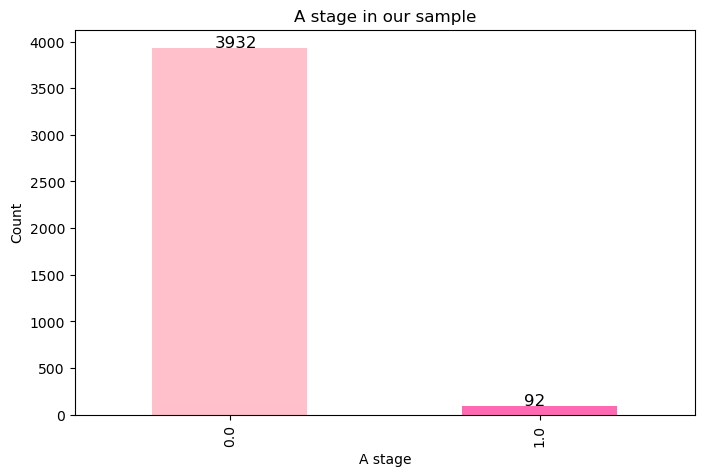

In [77]:
# Set the pinkish colors
colors = ['#FFC0CB', '#FF69B4', '#FF1493']  # Pinkish colors

# Group by 'Grade' and 'Race' and count the rows, specifying the desired order
grouped_df = df.groupby(['A Stage'])['Age'].count()

# Calculate the relative percentages within each grade
#relative_percentages = grouped_df.apply(lambda x: 100 * x / x.sum(), axis=1)


# Plot the unstacked bar graph
ax = grouped_df.plot.bar(color=colors)

# Set the style and labels for the plot
plt.rcParams['figure.figsize'] = (8, 5)  # Adjust the figure size as desired
plt.xlabel('A stage')
plt.ylabel('Count')
plt.title('A stage in our sample')

# Rotate the x-axis labels
#plt.xticks(rotation=45)
for index,data in enumerate(df.groupby(['A Stage'])['6th Stage'].count()):
    ax.text(x=index-0.05 , y =data+10 , s=f"{round(data)}" , fontdict=dict(fontsize=12))

plt.show()

# starting the pipline

In [5]:
def f_recall(y_true, y_pred):
    precision = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    if recall >0.80:
        answer = 0.8+ f1_score(y_true, y_pred)
        return answer
    else:
        return recall
def recall8_f1_scorer(y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    if recall >0.80:
        answer = recall+ f1
        return answer
    else:
        return recall
def recall8_precision_scorer(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    if recall >0.80:
        answer = recall+ precision
        return answer
    else:
        return recall

In [7]:
df = pd.read_csv('Breast_Cancer.csv')
df = cancer_encode_without_ms(df)
#df = cancer_encode(df)
df = cancer_features_select(df)
X = df.drop(['A Stage'], axis=1, inplace=False) #sould be without  
y = df['A Stage']

In [47]:
df = pd.read_csv('Breast_Cancer.csv')
df = cancer_encode_without_ms(df)
#df = cancer_encode(df)
df = cancer_features_select(df)
X = df.drop(['A Stage'], axis=1, inplace=False) #sould be without  
y = df['A Stage']

In [9]:
over = SMOTE()
scaler = StandardScaler() #אני מנסה פה להשתמש בסקלר בלי לעטוף חזרה את הנתונים בטבלת פנדה. אם זה לא יעבוד נעטוף בפונקציה נפרדת
logistic = LogisticRegression(max_iter=100000) #צריך להגדיר את המודל 
log_steps = [("scaler", scaler), ("over", over), ("logistic", logistic)]

pipe_log = Pipeline(steps=log_steps)

param_grid_log = {
    "over__sampling_strategy": [0.2,0.3,0.5,0.6,0.7,0.8],
    "over__k_neighbors": [6,7,8],
    "logistic__class_weight":[{0: 1, 1: 1},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 10}]
}
search_new = GridSearchCV(pipe_log, param_grid_log, n_jobs=5,scoring=make_scorer(recall8_precision_scorer))
search_new.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_new.best_score_)
print(search_new.best_params_)
log_estimator = search_new.best_estimator_
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores_log = cross_validate(log_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores_log)

Best parameter (CV score=1.178):
{'logistic__class_weight': {0: 1, 1: 2}, 'over__k_neighbors': 6, 'over__sampling_strategy': 0.7}
Mean f1:  0.298
Mean recall: 0.971
Mean precision: 0.176
cross_validation confusion matrix
     0       1
0  3514    418
1   3       89


In [12]:
over = SMOTE()
scaler = StandardScaler() #אני מנסה פה להשתמש בסקלר בלי לעטוף חזרה את הנתונים בטבלת פנדה. אם זה לא יעבוד נעטוף בפונקציה נפרדת
logistic = LogisticRegression(max_iter=100000) #צריך להגדיר את המודל 
clustering = KMeans(8)
#log_steps = [("encoder",encoder),("selector",selector),("scaler", scaler), ("over", over), ("logistic", logistic)]
log_steps = [("scaler", scaler),("clustering",clustering), ("over", over), ("logistic", logistic)]

pipe_log = Pipeline(steps=log_steps)

param_grid_log = {
    "over__sampling_strategy": [0.2,0.3,0.5,0.6,0.7,0.8],
    "over__k_neighbors": [6,7,8],
    "logistic__class_weight":[{0: 1, 1: 1},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 10}],
    "clustering__n_clusters":[1,9,3,5,8]
}
search_new = GridSearchCV(pipe_log, param_grid_log, n_jobs=5,scoring=make_scorer(recall8_precision_scorer))
search_new.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_new.best_score_)
print(search_new.best_params_)
log_estimator = search_new.best_estimator_
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores_log = cross_validate(log_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores_log)

Best parameter (CV score=1.172):
{'clustering__n_clusters': 8, 'logistic__class_weight': {0: 1, 1: 10}, 'over__k_neighbors': 8, 'over__sampling_strategy': 0.3}
Mean f1:  0.288
Mean recall: 0.985
Mean precision: 0.169
cross_validation confusion matrix
     0       1
0  3486    446
1   1       91


# evaluate pipeline


(0.0, 1.1)

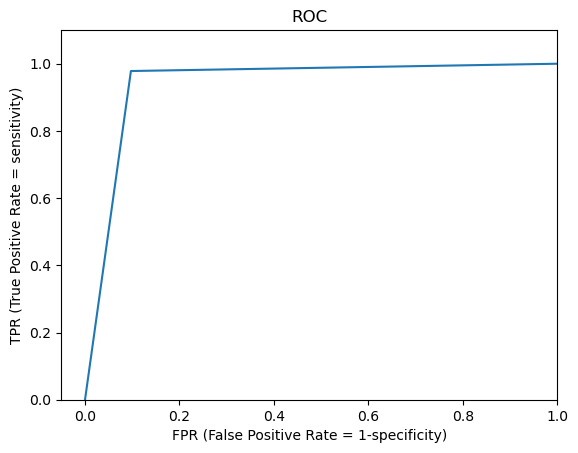

In [51]:
fpr, tpr, thresholds = roc_curve(y, log_estimator_new.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

# random forest

In [20]:
rf = RandomForestClassifier()
over = SMOTE()
scaler = StandardScaler()

rf_steps = [("scaler", scaler), ("over", over), ("rf", rf)]
pipe_rf = Pipeline(steps=rf_steps)

param_grid_rf = {
    "over__sampling_strategy": [0.1,0.2,0.3,0.5],
    "over__k_neighbors": [5,6,7,8],
    "rf__max_depth": [3,4,5,6],
    "rf__min_samples_leaf": [4,5,6,10],
    "rf__class_weight":[{0: 1, 1: 1},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 10}]
}
search_rf = GridSearchCV(pipe_rf, param_grid_rf, n_jobs=5,scoring=make_scorer(recall8_precision_scorer))
search_rf.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_rf.best_score_)
print(search_rf.best_params_)
rf_estimator =search_rf.best_estimator_
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(rf_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores)

Best parameter (CV score=1.175):
{'over__k_neighbors': 8, 'over__sampling_strategy': 0.1, 'rf__class_weight': {0: 1, 1: 3}, 'rf__max_depth': 3, 'rf__min_samples_leaf': 6}
Mean f1:  0.289
Mean recall: 0.968
Mean precision: 0.170
cross_validation confusion matrix
     0       1
0  3497    435
1   3       89


In [69]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(rf_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores)

Mean f1:  0.292
Mean recall: 0.995
Mean precision: 0.171
cross_validation confusion matrix
     0       1
0  3490    442
1   0       92


(0.0, 1.1)

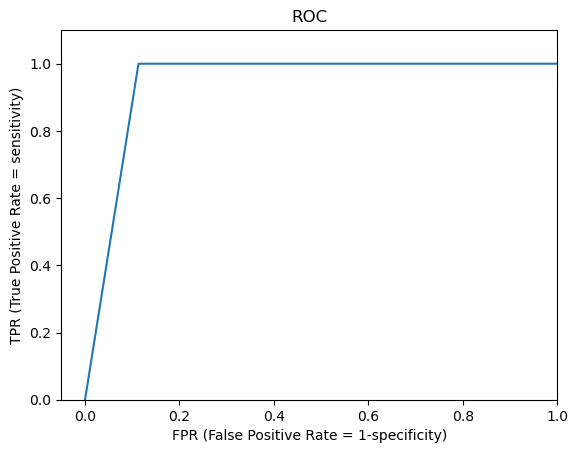

In [70]:
fpr, tpr, thresholds = roc_curve(y, rf_estimator.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

In [71]:
hd = list(X.columns)
print("feature importances: ")
for i, f in zip(hd, search_rf.best_estimator_.named_steps['rf'].feature_importances_):
     print(i,round(f*100,2))

feature importances: 
Age 0.22
T Stage  9.92
N Stage 16.95
6th Stage 28.81
Grade 0.98
Tumor Size 1.72
Estrogen Status 0.2
Progesterone Status 0.1
Regional Node Examined 1.03
Reginol Node Positive 7.54
Race_Black 0.05
Race_Other 0.04
Race_White 0.09
6th Stage_IIA 2.03
6th Stage_IIB 1.96
6th Stage_IIIA 2.26
6th Stage_IIIB 5.93
6th Stage_IIIC 14.06
Regional_Node_pos_% 5.96
Estrogen&Progesterone positive 0.11
Estrogen&Progesterone Negative 0.05


## draft, with clustering

In [51]:
rf = RandomForestClassifier()
over = SMOTE()
scaler = StandardScaler()
clustering = KMeans(8)

rf_steps = [("scaler", scaler),('clustering',clustering), ("over", over), ("rf", rf)]
pipe_rf = Pipeline(steps=rf_steps)

param_grid_rf = {
    "over__sampling_strategy": [0.1,0.2,0.3,0.5],
    "over__k_neighbors": [5,6,7,8],
    "rf__max_depth": [3,4,5,6],
    "rf__min_samples_leaf": [4,5,6,10],
    "rf__class_weight":[{0: 1, 1: 1},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 6}]
}
search_rf = GridSearchCV(pipe_rf, param_grid_rf, n_jobs=5,scoring=make_scorer(recall8_f1_scorer))
search_rf.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_rf.best_score_)
print(search_rf.best_params_)
rf_estimator =search_rf.best_estimator_
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(rf_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores)

Best parameter (CV score=1.250):
{'over__k_neighbors': 5, 'over__sampling_strategy': 0.3, 'rf__class_weight': {0: 1, 1: 6}, 'rf__max_depth': 4, 'rf__min_samples_leaf': 10}
Mean f1:  0.257
Mean recall: 0.940
Mean precision: 0.149
cross_validation confusion matrix
     0       1
0  3438    494
1   6       86


# xgboost

In [6]:
XGB = XGBClassifier(n_estimators=700)
over = SMOTE()
scaler = StandardScaler() #אני מנסה פה להשתמש בסקלר בלי לעטוף חזרה את הנתונים בטבלת פנדה. אם זה לא יעבוד נעטוף בפונקציה נפרדת
XGB_steps = [("scaler", scaler), ("over", over), ("XGB", XGB)]
pipe_XGB= Pipeline(steps=XGB_steps)

param_grid_XGB = {
    "over__sampling_strategy": [0.4,0.5],
    "over__k_neighbors": [7,9],
    "XGB__max_depth": [3,4],
    "XGB__scale_pos_weight": [5,10,50,80],
    #'XGB__subsample': [1.0],
    #"XGB__colsample_bytree": [1.0],
    "XGB__gamma":[ 2,3,5],
    "XGB__learning_rate":[0.05,0.1,0.01],
}

In [9]:
XGB_search = GridSearchCV(pipe_XGB, param_grid_XGB, n_jobs=4,scoring=make_scorer(recall8_precision_scorer))
XGB_search.fit(X, y)
XGB_estimator =XGB_search.best_estimator_
print("Best parameter (CV score=%0.3f):" % XGB_search.best_score_)
print(XGB_search.best_params_)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(XGB_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores)

Best parameter (CV score=1.133):
{'XGB__gamma': 5, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__scale_pos_weight': 80, 'over__k_neighbors': 9, 'over__sampling_strategy': 0.5}
Mean f1:  0.294
Mean recall: 0.930
Mean precision: 0.175
cross_validation confusion matrix
     0       1
0  3528    404
1   6       86


In [18]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(XGB_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores)

Mean f1:  0.296
Mean recall: 0.935
Mean precision: 0.176


(0.0, 1.1)

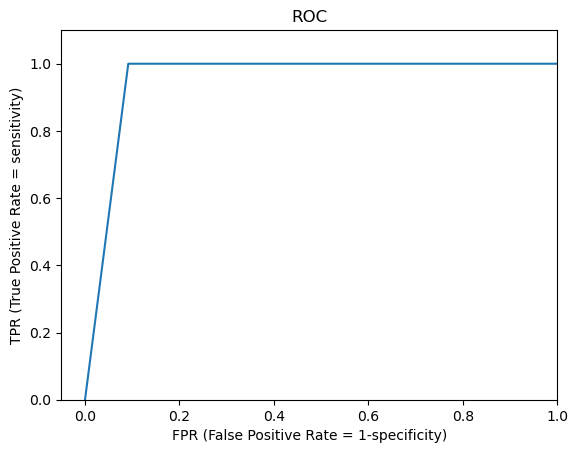

In [23]:
fpr, tpr, thresholds = roc_curve(y, XGB_estimator.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

In [56]:
XGB = XGBClassifier(n_estimators=700)
over = SMOTE()
scaler = StandardScaler() 
XGB_steps = [("scaler", scaler), ("over", over), ("XGB", XGB)]
pipe_XGB= Pipeline(steps=XGB_steps)

param_grid_XGB = {
    "over__sampling_strategy": [0.4,0.5,0.6],
    "over__k_neighbors": [7,9],
    "XGB__max_depth": [3,4,5],
    "XGB__scale_pos_weight": [10,50,80,90],
    #'XGB__subsample': [0.8,1.0],
    #"XGB__colsample_bytree": [0.8,1.0],
    "XGB__gamma":[ 2,3,5],
    "XGB__learning_rate":[0.05,0.01]
}

In [26]:
XGB_search = GridSearchCV(pipe_XGB, param_grid_XGB, n_jobs=4,scoring=make_scorer(recall8_f1_scorer))
XGB_search.fit(X, y)
XGB_estimator =XGB_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % XGB_search.best_score_)
print(XGB_search.best_params_)

Best parameter (CV score=1.280):
{'XGB__colsample_bytree': 0.8, 'XGB__gamma': 2, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__scale_pos_weight': 90, 'XGB__subsample': 1.0, 'over__k_neighbors': 9, 'over__sampling_strategy': 0.5}


In [57]:
XGB_search = GridSearchCV(pipe_XGB, param_grid_XGB, n_jobs=4,scoring=make_scorer(recall8_f1_scorer))
XGB_search.fit(X, y)
XGB_estimator =XGB_search.best_estimator_
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(XGB_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores)

Mean f1:  0.296
Mean recall: 0.951
Mean precision: 0.175
cross_validation confusion matrix
     0       1
0  3520    412
1   5       87


# lgbm

newer

In [74]:
LGBM = LGBMClassifier(learning_rate=0.01)
LGBM_steps = [("scaler", scaler), ("over", over), ("LGBM", LGBM)]
pipe_LGBM = Pipeline(steps=LGBM_steps)

param_grid_LGBM = {
    "over__sampling_strategy": [0.1,0.2,0.3,0.4,0.5],
    "over__k_neighbors": [6,7,8],
    "LGBM__max_depth": [3,4,6,7,8],
    "LGBM__class_weight":[{0: 1, 1: 10},{0: 1, 1: 15},{0: 1, 1: 3},{0: 1, 1: 5},{0: 1, 1: 6}],
     "LGBM__lambda_l1":[0,1,2]
}
LGBM_search = GridSearchCV(pipe_LGBM, param_grid_LGBM, n_jobs=5,scoring=make_scorer(recall8_f1_scorer))
LGBM_search.fit(X, y)
LGBM_estimator =LGBM_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % LGBM_search.best_score_)
print(LGBM_search.best_params_)

Best parameter (CV score=1.304):
{'LGBM__class_weight': {0: 1, 1: 5}, 'LGBM__lambda_l1': 1, 'LGBM__max_depth': 4, 'over__k_neighbors': 6, 'over__sampling_strategy': 0.3}


In [75]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(LGBM_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores)

Mean f1:  0.292
Mean recall: 0.973
Mean precision: 0.172
cross_validation confusion matrix
     0       1
0  3501    431
1   2       90


(0.0, 1.1)

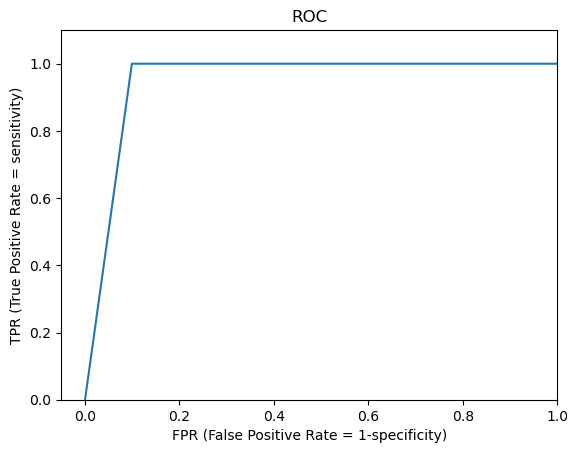

In [14]:
fpr, tpr, thresholds = roc_curve(y, LGBM_estimator.predict(X), pos_label=1)
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.1])

In [12]:
over = SMOTE()
scaler = StandardScaler() #אני מנסה פה להשתמש בסקלר בלי לעטוף חזרה את הנתונים בטבלת פנדה. אם זה לא יעבוד נעטוף בפונקציה נפרדת

LGBM = LGBMClassifier(learning_rate=0.01)
LGBM_steps = [("scaler", scaler), ("over", over), ("LGBM", LGBM)]
pipe_LGBM = Pipeline(steps=LGBM_steps)

param_grid_LGBM = {
    "over__sampling_strategy": [0.1,0.2,0.3,0.4,0.5],
    "over__k_neighbors": [6,7,8],
    "LGBM__max_depth": [3,4,6,7,8],
    "LGBM__class_weight":[{0: 1, 1: 10},{0: 1, 1: 15},{0: 1, 1: 3},{0: 1, 1: 5},{0: 1, 1: 6}],
     "LGBM__lambda_l1":[0,1,2]
}
LGBM_search = GridSearchCV(pipe_LGBM, param_grid_LGBM, n_jobs=5,scoring=make_scorer(recall8_precision_scorer))
LGBM_search.fit(X, y)
LGBM_estimator =LGBM_search.best_estimator_

print("Best parameter (CV score=%0.3f):" % LGBM_search.best_score_)
print(LGBM_search.best_params_)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_validate(LGBM_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores)

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
Best parameter (CV score=1.178):
{'LGBM__class_weight': {0: 1, 1: 15}, 'LGBM__lambda_l1': 1, 'LGBM__max_depth': 8, 'over__k_neighbors': 6, 'over__sampling_strategy': 0.5}
Mean f1:  0.292
Mean recall: 0.982
Mean precision: 0.171
cross_validation confusion matrix
     0       1
0  3495    437
1   2       90


In [13]:
hd = list(X.columns)
print("feature importances: ")
for i, f in zip(hd, LGBM_search.best_estimator_.named_steps['LGBM'].feature_importances_):
     print(i,round(f,2))

feature importances: 
Age 287
T Stage  433
N Stage 0
6th Stage 100
Grade 61
Tumor Size 201
Estrogen Status 0
Progesterone Status 37
Regional Node Examined 367
Reginol Node Positive 182
Race_Black 7
Race_Other 1
Race_White 116
6th Stage_IIA 0
6th Stage_IIB 0
6th Stage_IIIA 0
6th Stage_IIIB 0
6th Stage_IIIC 0
Regional_Node_pos_% 495
Estrogen&Progesterone positive 29
Estrogen&Progesterone Negative 0


# voting 

In [62]:
y_preds = pd.DataFrame(y.copy())
y_preds["logistic"] = log_estimator.predict(X)
y_preds["RF"] = rf_estimator.predict(X)
y_preds["LGBM"] = LGBM_estimator.predict(X)
y_preds["XGB"] = XGB_estimator.predict(X)

#y_pred["xgboost"] =XGB_estimator.predict(X)
y_preds['vote'] = np.where(y_preds["logistic"]+y_preds["RF"]+y_preds["LGBM"]>2,1,0)


In [66]:
y_preds[['logistic','RF','LGBM','XGB']].corr()

,logistic,RF,LGBM,XGB
logistic,1.000000,0.916692,0.984975,0.962229
RF,0.916692,1.000000,0.903875,0.881295
LGBM,0.984975,0.903875,1.000000,0.976907
XGB,0.962229,0.881295,0.976907,1.000000


In [42]:
y_preds['correct'] = np.where(y_preds['vote']==y_preds['A Stage'],1,0)
y_group = y_preds.groupby(['A Stage','vote'])['A Stage'].count().unstack().fillna(0)

In [34]:
y_group

vote,0,1
A Stage,,
0.0,3517,415
1.0,1,91


In [69]:
from sklearn.ensemble import VotingClassifier
classifiers = [('LR', log_estimator), ('RF', rf_estimator),('LGBM', LGBM_estimator),('xgboost',XGB_estimator)]
clf_voting = VotingClassifier(estimators=classifiers,
                              voting='hard')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_validate(clf_voting, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores)

Mean f1:  0.289
Mean recall: 0.985
Mean precision: 0.169
cross_validation confusion matrix
     0       1
0  3487    445
1   1       91


# trying to predict a stage without 6th stage - not so bed results

In [73]:
df.groupby(['A Stage', '6th Stage'])['A Stage'].count()

A Stage  6th Stage
0.0      0.0          1305
         1.0          1130
         2.0          1050
         3.0            43
         4.0           404
1.0      3.0            24
         4.0            68
Name: A Stage, dtype: int64

In [76]:
df = pd.read_csv('Breast_Cancer.csv')
df = cancer_encode_without_ms(df)
#df = cancer_encode(df)
df = cancer_features_select(df)
X = df.drop(['A Stage','6th Stage_IIA', '6th Stage_IIB', '6th Stage_IIIA', '6th Stage_IIIB',
       '6th Stage_IIIC','6th Stage'], axis=1, inplace=False) #sould be without  
y = df['A Stage']

In [75]:
X.columns

Index(['Age', 'T Stage ', 'N Stage', '6th Stage', 'Grade', 'Tumor Size',
       'Estrogen Status', 'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Race_Black', 'Race_Other', 'Race_White',
       '6th Stage_IIA', '6th Stage_IIB', '6th Stage_IIIA', '6th Stage_IIIB',
       '6th Stage_IIIC', 'Regional_Node_pos_%',
       'Estrogen&Progesterone positive', 'Estrogen&Progesterone Negative'],
      dtype='object')

In [77]:
over = SMOTE()
scaler = StandardScaler() #אני מנסה פה להשתמש בסקלר בלי לעטוף חזרה את הנתונים בטבלת פנדה. אם זה לא יעבוד נעטוף בפונקציה נפרדת
logistic = LogisticRegression(max_iter=100000) #צריך להגדיר את המודל 
log_steps = [("scaler", scaler), ("over", over), ("logistic", logistic)]

pipe_log = Pipeline(steps=log_steps)

param_grid_log = {
    "over__sampling_strategy": [0.2,0.3,0.5,0.6,0.7,0.8],
    "over__k_neighbors": [6,7,8],
    "logistic__class_weight":[{0: 1, 1: 1},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 10}]
}
search_new = GridSearchCV(pipe_log, param_grid_log, n_jobs=5,scoring=make_scorer(recall8_precision_scorer))
search_new.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_new.best_score_)
print(search_new.best_params_)
log_estimator = search_new.best_estimator_
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores_log = cross_validate(log_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores_log)

Best parameter (CV score=1.075):
{'logistic__class_weight': {0: 1, 1: 10}, 'over__k_neighbors': 7, 'over__sampling_strategy': 0.7}
Mean f1:  0.205
Mean recall: 0.949
Mean precision: 0.115
cross_validation confusion matrix
     0       1
0  3261    671
1   5       87


In [78]:
rf = RandomForestClassifier()
over = SMOTE()
scaler = StandardScaler()

rf_steps = [("scaler", scaler), ("over", over), ("rf", rf)]
pipe_rf = Pipeline(steps=rf_steps)

param_grid_rf = {
    "over__sampling_strategy": [0.1,0.2,0.3,0.5],
    "over__k_neighbors": [5,6,7,8],
    "rf__max_depth": [3,4,5,6],
    "rf__min_samples_leaf": [4,5,6,10],
    "rf__class_weight":[{0: 1, 1: 1},{0: 1, 1: 2},{0: 1, 1: 3},{0: 1, 1: 10}]
}
search_rf = GridSearchCV(pipe_rf, param_grid_rf, n_jobs=5,scoring=make_scorer(recall8_precision_scorer))
search_rf.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search_rf.best_score_)
print(search_rf.best_params_)
rf_estimator =search_rf.best_estimator_
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scores = cross_validate(rf_estimator, X, y, scoring=['recall','f1','precision'], cv=cv, n_jobs=-1)
cross_validation_report(df,'A Stage',scores)

Best parameter (CV score=1.089):
{'over__k_neighbors': 6, 'over__sampling_strategy': 0.5, 'rf__class_weight': {0: 1, 1: 3}, 'rf__max_depth': 5, 'rf__min_samples_leaf': 10}
Mean f1:  0.269
Mean recall: 0.890
Mean precision: 0.159
cross_validation confusion matrix
     0       1
0  3498    434
1   10       82


In [82]:
hd = list(X.columns)
print("feature importances: ")
for i, f in zip(hd, search_rf.best_estimator_.named_steps['rf'].feature_importances_):
     print(i,round(f,2))

feature importances: 
Age 0.01
T Stage  0.19
N Stage 0.31
Grade 0.04
Tumor Size 0.06
Estrogen Status 0.01
Progesterone Status 0.01
Regional Node Examined 0.04
Reginol Node Positive 0.21
Race_Black 0.0
Race_Other 0.0
Race_White 0.01
Regional_Node_pos_% 0.11
Estrogen&Progesterone positive 0.01
Estrogen&Progesterone Negative 0.0
